# Fingerprint Detection

### Objectives:
- Implement a Convolutional Neural Network (CNN) for fingerprint detection;
- Train and evaluate the model using the modified fingerprints (Altered dataset);
- Test the model using the real fingerprints (raw data).

In [1]:
import os
import cv2
import random
import itertools
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, regularizers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Defining utility functions

In [2]:
img_size = 96

def load_data(path, altered=True):
    """ Loads the fingerprint images.
    
    Args:
        path (str): path containing the fingerprint images
        altered (bool): altered or original fingerprint images (default=True)
        
    Returns:
        data (list): dataset of fingerprint images (user_id, fingernumber, image) 
    """
    
    print("Loading data from: ", path)
    data = []
    for img in os.listdir(path):
        imgname, ext = os.path.splitext(img)
        ID, etc = imgname.split('__')
        
        # Decrementing id by 1 (to_categorical encodes starting from 0)
        ID = int(ID) - 1
        
        # Extracting hand and finger information (altered images have additional info - type of modification)
        if altered:
            _, hand, finger, _, _ = etc.split('_')
        else:
            _, hand, finger, _  = etc.split('_')
        
        # Encoding fingers (left hand corresponding to 0-4 and right hand corresponding to 5-9)
        if hand=='Left':
            base = 0
        else: base  = 5
        if finger=="little":
            fingerNum = base + 0
        elif finger=='ring':
            fingerNum = base + 1
        elif finger=='middle':
            fingerNum = base + 2
        elif finger=='index':
            fingerNum = base + 3 
        else: fingerNum = base + 4
        
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img_array, (img_size, img_size))
        data.append([ID, fingerNum, img_resize])
    return data

In [106]:
 def display_header(text):
    header = "-- " + text + " --"
    print("-"*len(header))
    print(header)
    print("-"*len(header))

## 1. Loading fingerprint data
___

We have 4 folders containing fingerprint images:
- Altered-Easy
- Altered-Medium
- Altered-Hard
- Real

Let's load each one of them using the `load_data` function:

In [102]:
altered_images_path = "../data/SOCOFing/Altered/Altered-"
real_images_path = "../data/SOCOFing/Real"

# Loading the altered data
easy_data = load_data(altered_images_path+'Easy', altered=True)
medium_data = load_data(altered_images_path+'Medium', altered=True)
hard_data = load_data(altered_images_path+'Hard', altered=True)

# Concatenating altered data
altered_data = np.concatenate([easy_data, medium_data, hard_data], axis=0, dtype=object)

# Freeing memory
del easy_data, medium_data, hard_data

# Loading the real data
real_data = np.array(load_data(real_images_path, altered=False), dtype=object)

Loading data from:  ../data/SOCOFing/Altered/Altered-Easy
Loading data from:  ../data/SOCOFing/Altered/Altered-Medium
Loading data from:  ../data/SOCOFing/Altered/Altered-Hard
Loading data from:  ../data/SOCOFing/Real


In [107]:
display_header("Number of samples")
print(f"> Altered data: {len(altered_data)}")
print(f"> Real data:    {len(real_data)}")

-----------------------
-- Number of samples --
-----------------------
> Altered data: 49270
> Real data:    6000


In [104]:
# Counting unique users
num_classes = len(np.unique(real_data[:, 0]))
print(f"> There are {num_classes} unique user_ids")

> There are 600 unique user_ids


## 2. Preparing the Data
___

Here, we'll create the datasets for training, validating and testing our model.

The modified data (Altered dataset) will be used for training and validating, and the real data (unmodified fingerprints) will be used for testing.

### 2.1 Creating the training and validation datasets

In [7]:
X_altered, y_subjectID_altered = [], []

for subjectID, _, feature in altered_data:
    X_altered.append(feature)
    y_subjectID_altered.append(subjectID)

X_altered = np.array(X_altered).reshape(-1, img_size, img_size, 1)
X_altered = X_altered / 255.0  # Normalizing to [0, 1] 
y_subjectID_altered = to_categorical(y_subjectID_altered, num_classes=num_classes)

X_train, X_val, y_train, y_val = train_test_split(X_altered, y_subjectID_altered, test_size=0.2, random_state=2)

# Freeing memory
del altered_data, X_altered, y_subjectID_altered

### 2.2 Creating the testing dataset

In [8]:
# Creating the testing dataset
X_test, y_test = [], []

for subjectID, _, feature in real_data:
    X_test.append(feature)
    y_test.append(subjectID)

X_test = np.array(X_test).reshape(-1, img_size, img_size, 1)
X_test = X_test / 255.0

y_test = to_categorical(y_test, num_classes=num_classes)

# Freeing memory
del real_data

### 2.3 Visualizing data split

In [9]:
print("------------------------------------------------")
print(" Split           Feature shape      label shape")
print("------------------------------------------------")
print(f" Train:       {str(X_train.shape):<18}    {y_train.shape}")
print(f" Validation:  {str(X_val.shape):<18}    {y_val.shape}")
print(f" Test:        {str(X_test.shape):<18}    {y_test.shape}")

 Split           Feature shape      label shape
------------------------------------------------
 Train:       (39416, 96, 96, 1)    (39416, 600)
 Validation:  (9854, 96, 96, 1)     (9854, 600)
 Test:        (6000, 96, 96, 1)     (6000, 600)


## 3. Model Training e Evaluation
___

### 3.1 Creating the CNN Architecture

In [10]:
final_dense_units = num_classes

model = Sequential(name="Contact_Fingerprint_Model")
model.add(layers.Conv2D(32, (5, 5), activation='relu', 
                        kernel_regularizer=regularizers.l2(0.001), 
                        input_shape = (img_size, img_size, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64,(5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128,(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(final_dense_units, activation='softmax'))

# Complete with Adam optimizer and entropy cost
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "Contact_Fingerprint_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 92, 92, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 92, 92, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 42, 42, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 1

### 3.2 Visualizing the model

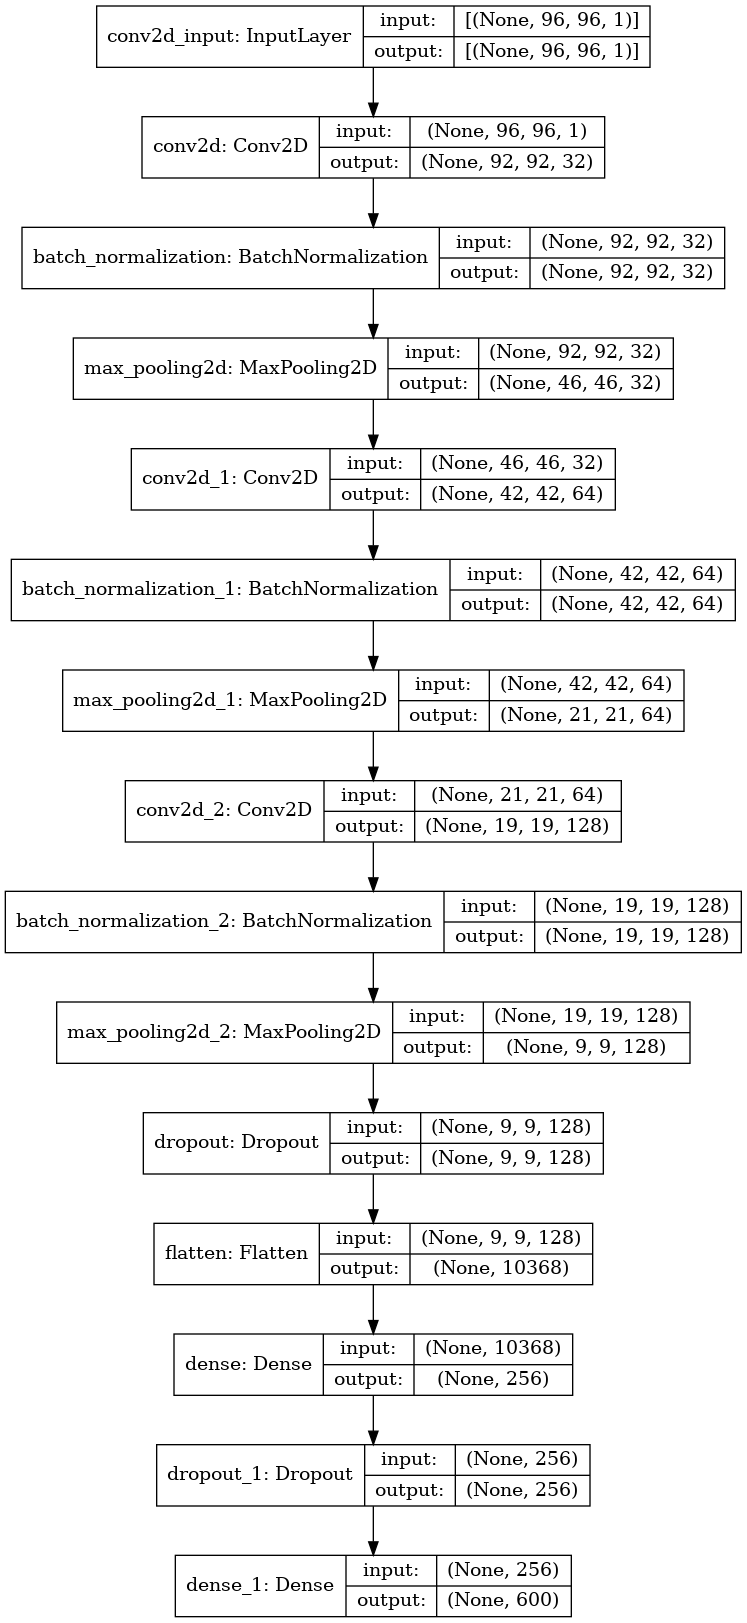

In [11]:
plot_model(model, show_shapes=True, to_file='./model_architecture.png')

### 3.3 Training the model

In [12]:
ReduceLR_minlr = 1e-9
epochs = 20
batch_size = 64

CallBack = [
    callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1),
    callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr, verbose=1),
    callbacks.TensorBoard(log_dir="./log_dir/")]

start_time = datetime.now()
history = model.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (X_val, y_val),
                    verbose = 1,
                    callbacks= CallBack)
end_time = datetime.now()

print(f"\nExecution Time: {end_time - start_time}")

Epoch 1/20
616/616 [==============================] - 264s 428ms/step - loss: 6.5169 - accuracy: 0.0040 - val_loss: 6.3693 - val_accuracy: 0.0093
Epoch 2/20
616/616 [==============================] - 268s 435ms/step - loss: 6.0444 - accuracy: 0.0231 - val_loss: 5.4597 - val_accuracy: 0.0692
Epoch 3/20
616/616 [==============================] - 268s 435ms/step - loss: 4.9238 - accuracy: 0.1140 - val_loss: 3.8176 - val_accuracy: 0.3710
Epoch 4/20
616/616 [==============================] - 268s 435ms/step - loss: 3.3152 - accuracy: 0.3348 - val_loss: 2.0204 - val_accuracy: 0.7227
Epoch 5/20
616/616 [==============================] - 269s 436ms/step - loss: 1.9606 - accuracy: 0.5840 - val_loss: 1.0982 - val_accuracy: 0.8774
Epoch 6/20
616/616 [==============================] - 269s 436ms/step - loss: 1.1702 - accuracy: 0.7550 - val_loss: 0.5896 - val_accuracy: 0.9352
Epoch 7/20
616/616 [==============================] - 269s 437ms/step - loss: 0.7671 - accuracy: 0.8472 - val_loss: 0.3820 -

### 3.4 Visualizing the training process

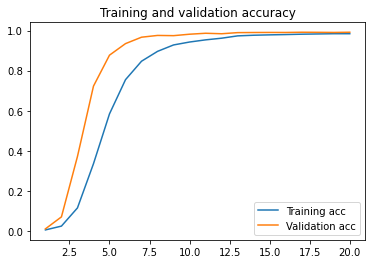

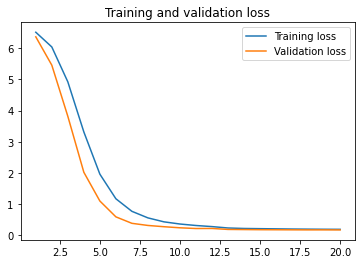

Id Recognition accuracy: 99.75%


In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
# plot figures models
plt.figure()
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

testing_acc = model.evaluate([X_test], [y_test], verbose=0)
print(f"Id Recognition accuracy: {testing_acc[1]*100:.2f}%")

### 3.5 Testing Model

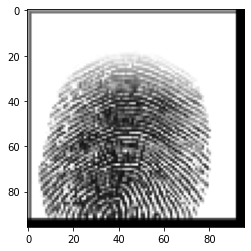

------------------
-- Test Results --
------------------
> Real User Id: 23
> Predicted Id: 23


In [110]:
# Randomly pick a fingerprint from test data to predict the user_id
rand_fp_num = random.randint(0, len(X_test)-1)
plt.imshow(X_test[rand_fp_num].reshape((96, 96)), cmap ='gray')
plt.show()

# Get the selected fingerprint and reshape (CNN input layer)
selected_fp = X_test[rand_fp_num].reshape(-1, img_size, img_size, 1)

# Predictions
id_pred = np.argmax(model.predict(selected_fp))
id_real = np.argmax(y_test[rand_fp_num])

display_header("Test Results")
print(f"> Real User Id: {id_real}")
print(f"> Predicted Id: {id_pred}")